In [18]:
!pip install scikeras

In [19]:
import pandas as pd
import numpy as np
import random

from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedGroupKFold, KFold
import keras as keras
import tensorflow as tf
import scikeras
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, make_scorer, accuracy_score, recall_score, precision_score
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)


import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import plot_model

print("Tensorflow version:",tf.__version__)
print("Keras version:",keras.__version__)
print("Scikeras version:",scikeras.__version__)

import os
from google.colab import drive
drive.mount('/content/drive')

Tensorflow version: 2.18.0
Keras version: 3.8.0
Scikeras version: 0.13.0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
seed_value= 42

os.environ['PYTHONHASHSEED']=str(seed_value)

random.seed(seed_value)

np.random.seed(seed_value)

tf.random.set_seed(seed_value)

In [21]:
filepath = '/content/drive/My Drive/EColi_ML_CSV_files/'

All_Drugs_df = pd.read_csv(filepath+"EColi_Merged_df.csv", na_values="NaN")
All_Drugs_df.head()

<ipython-input-21-c2555a6b2d8b>:5: DtypeWarning: Columns (5,6,7,8,10,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  All_Drugs_df = pd.read_csv(filepath+"EColi_Merged_df.csv", na_values="NaN")


,MLST,Isolate,Year,CTZ,CTX,AMP,AMX,AMC,TZP,CXM,...,group_48768,group_48873,group_48916,group_48933,group_48937,group_48958,group_49020,group_49174,group_49253,group_49257
0,ST68,11679_6#21,2001.0,S,NaN,NaN,S,S,S,R,...,0,0,0,0,0,0,0,0,0,0
1,ST652,11658_6#85,2005.0,S,S,NaN,S,S,S,S,...,0,0,0,0,0,0,0,0,0,0
2,ST95,11657_6#45,2005.0,S,S,NaN,R,R,R,S,...,0,0,0,0,0,0,0,0,0,0
3,ST73,11658_4#53,2005.0,S,S,NaN,R,S,S,S,...,0,0,0,0,0,0,0,0,0,0
4,ST73,11658_4#54,2005.0,S,S,NaN,R,S,S,S,...,0,0,0,0,0,0,0,0,0,0


In [22]:
drug_list = All_Drugs_df.iloc[:,3:15].columns

for drug in drug_list:
  All_Drugs_df.loc[All_Drugs_df[drug] == "S", drug] = 1.0

for drug in drug_list:
  All_Drugs_df.loc[All_Drugs_df[drug] == "R", drug] = 0.0

All_Drugs_df.head()

,MLST,Isolate,Year,CTZ,CTX,AMP,AMX,AMC,TZP,CXM,...,group_48768,group_48873,group_48916,group_48933,group_48937,group_48958,group_49020,group_49174,group_49253,group_49257
0,ST68,11679_6#21,2001.0,1.0,NaN,NaN,1.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,ST652,11658_6#85,2005.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,ST95,11657_6#45,2005.0,1.0,1.0,NaN,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,ST73,11658_4#53,2005.0,1.0,1.0,NaN,0.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,ST73,11658_4#54,2005.0,1.0,1.0,NaN,0.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
def Split_train_test(drug):
  df_list = [All_Drugs_df[["MLST","Isolate",drug,"Year"]], All_Drugs_df.iloc[:,15:]]

  Drug_df = pd.concat(df_list, axis=1)

  Drug_df = Drug_df.dropna()

  Train_test_dic = {}

  labels = Drug_df[drug]

  features = Drug_df.drop(columns=[drug])

  features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20, random_state=seed_value, stratify=labels)

  Train_test_dic['labels_train'] = labels_train
  Train_test_dic['features_train'] = features_train
  Train_test_dic['labels_test'] = labels_test
  Train_test_dic['features_test'] = features_test

  return Train_test_dic

In [24]:
AMX_Train_test_dic = Split_train_test("AMX")

print("AMX")
for k, df in AMX_Train_test_dic.items():
  print(k, df.shape)
  if k.startswith("labels"):
    print(df.value_counts())

AMX
labels_train (875,)
AMX
0.0    529
1.0    346
Name: count, dtype: int64
features_train (875, 17201)
labels_test (219,)
AMX
0.0    133
1.0     86
Name: count, dtype: int64
features_test (219, 17201)


In [25]:
combo_list = ['Y', 'G', 'GY']

def combo_feat(features_df, drug, combo):

  year_filter = [col for col in features_df if col.startswith("Year")]
  year_feat = features_df[year_filter]

  gene_presc_filter = [col for col in features_df.columns if col not in year_filter and col != "Isolate"]
  gene_presc_feat = features_df[gene_presc_filter]

  if combo == 'Y':
    df_list = [features_df[['MLST','Isolate']], year_feat]
    Y_feat_df_t = pd.concat(df_list, axis=1)
    Y_feat_df_t = Y_feat_df_t.drop(columns=['Isolate'])
    return Y_feat_df_t

  if combo == 'G':
    df_list = [features_df['Isolate'], gene_presc_feat]
    G_feat_df = pd.concat(df_list, axis=1)
    G_feat_df = G_feat_df.drop(columns=['Isolate'])
    return G_feat_df

  if combo == 'GY':
    df_list = [features_df['Isolate'], year_feat, gene_presc_feat]
    GY_feat_df_t = pd.concat(df_list, axis=1)
    GY_feat_df_t = GY_feat_df_t.drop(columns=['Isolate'])
    return GY_feat_df_t

In [26]:
AMX_GY_train_df = combo_feat(AMX_Train_test_dic['features_train'],"AMX","GY")

AMX_GY_train_df.head()

,Year,MLST,yeiU,yhhS,ybaE,eutR,ibrB,ytfP,aslB,narQ,...,group_48768,group_48873,group_48916,group_48933,group_48937,group_48958,group_49020,group_49174,group_49253,group_49257
662,2002.0,ST641,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
75,2005.0,ST73,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
196,2006.0,ST405,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
540,2009.0,ST415,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
127,2006.0,ST131,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [27]:
AMX_GY_train_df.shape

(875, 17200)

In [28]:
def run_NN(feat_train_df, lab_train, drug, combo,fit = True, view_training = True, view_epoch=0, lr=0.0001, rate=0.8):
  print(drug +" Training combo: "+ combo)

  class_labels = np.unique(lab_train)
  reweight = compute_class_weight(class_weight='balanced', classes=class_labels, y=lab_train)

  feat = feat_train_df.drop(columns=['MLST'])
  scaler = MinMaxScaler()
  feat_array_t = scaler.fit_transform(feat)
  NN = Sequential()
  NN.add(Dense(200,activation='relu'))
  NN.add(Dropout(rate, seed=seed_value))
  NN.add(Dense(100 ,activation='relu'))
  NN.add(Dropout(rate, seed=seed_value))
  NN.add(Dense(1, activation = 'sigmoid', kernel_initializer=keras.initializers.glorot_uniform(seed=seed_value)))
  early_stopping_monitor= EarlyStopping(patience=10)
  NN.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=lr) ,loss= 'binary_crossentropy', weighted_metrics=['accuracy'])
  if fit == True:
    NN_history = NN.fit(x=feat_array_t, y=lab_train.to_numpy(dtype=float) , validation_split=0.2, callbacks= [early_stopping_monitor], epochs=10, batch_size=128, class_weight=dict(enumerate(reweight)), verbose=view_epoch)
    if view_training == True:
      fig, (ax1, ax2) = plt.subplots(1, 2)
      fig.suptitle('Training History')
      print(NN_history.history.keys())
      ax1.plot(NN_history.history['accuracy'])
      ax1.plot(NN_history.history['val_accuracy'])
      ax1.set_title('model accuracy')
      ax1.set(ylabel='accuracy', xlabel='epochs')

      ax2.plot(NN_history.history['loss'])
      ax2.plot(NN_history.history['val_loss'])
      ax2.set_title('model loss')
      ax2.set(ylabel='loss', xlabel='epochs')
      ax2.legend(['train', 'validation'], loc='best')
      fig.tight_layout()
      filepath='/content/drive/My Drive/EColi_ML_Plots/'
      plt.savefig(filepath + 'NN_' + drug + '_' + combo + '_' + 'training_history.jpg',dpi=400, bbox_inches="tight")
    return NN
  else:
    return NN

AMX Training combo: GY
Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.4885 - loss: 0.8764 - val_accuracy: 0.6229 - val_loss: 0.6789
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.5013 - loss: 0.8343 - val_accuracy: 0.6229 - val_loss: 0.6688
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.5156 - loss: 0.7789 - val_accuracy: 0.6571 - val_loss: 0.6718
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.5333 - loss: 0.7272 - val_accuracy: 0.6514 - val_loss: 0.6713
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.4935 - loss: 0.7335 - val_accuracy: 0.6457 - val_loss: 0.6633
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.5712 - loss: 0.6882 - val_accuracy: 0.6514 - val_loss: 0.6548
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.5241 - loss: 0.7079 - val_accuracy: 0.6114 - val_loss: 0.6564
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.5475 - loss: 0.6902 - val_accuracy

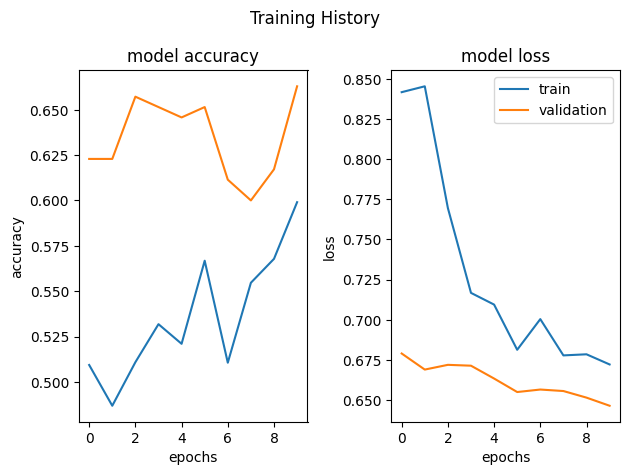

In [29]:
NN_AMX_GY_model = run_NN(AMX_GY_train_df, AMX_Train_test_dic['labels_train'], drug="AMX",combo="GY", view_epoch=1)

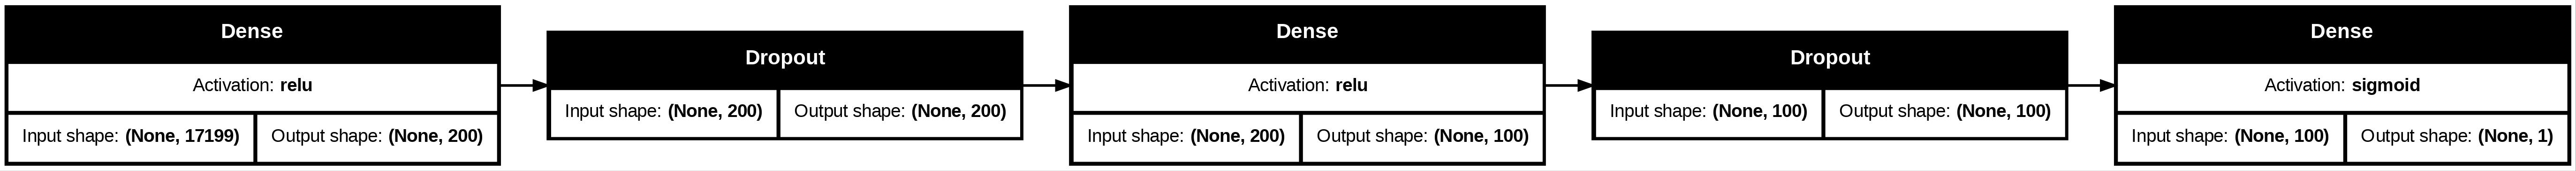

In [30]:
plot_model(NN_AMX_GY_model, to_file='/content/drive/MyDrive/EColi_ML_Plots/NN_AMX_GY_model_Architechture.jpg', show_shapes=True, show_layer_activations=True, rankdir='LR')

In [31]:
NN_AMX_GY_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │     3,440,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,380,605 (39.60 MB)

 Trainable params: 3,460,201 (13.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,920,404 (26.40 MB)

6) Making predictions from Neural Network model

In [32]:
def predict(NN_combo_Model, features_test):
  feat = features_test.drop(columns=['MLST'])
  scaler = MinMaxScaler()
  feat_t = scaler.fit_transform(feat)
  labels_pred = NN_combo_Model.predict(feat_t)
  labels_pred = np.where(labels_pred < 0.5, 0, 1).reshape((len(labels_pred),))
  return labels_pred

In [33]:
AMX_GY_test_df = combo_feat(AMX_Train_test_dic['features_test'],"AMX","GY")
AMX_GY_test_df.head()

,Year,MLST,yeiU,yhhS,ybaE,eutR,ibrB,ytfP,aslB,narQ,...,group_48768,group_48873,group_48916,group_48933,group_48937,group_48958,group_49020,group_49174,group_49253,group_49257
381,2008.0,ST73,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
793,2002.0,ST59,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
95,2005.0,ST38,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
0,2001.0,ST68,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
516,2009.0,ST405,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [34]:
AMX_GY_labels_pred = predict(NN_AMX_GY_model,AMX_GY_test_df)

print("Labels predicted: ")
print(AMX_GY_labels_pred)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Labels predicted: 
[0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 1 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 1
 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0
 1 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0
 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 1
 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]


In [35]:
def evaluate(NN_combo_model, features_test, labels_test, labels_pred, cf= True, show_results= True, tunned = False):

  labels_test = np.asarray(labels_test,float)
  feat = features_test.drop(columns=['MLST'])
  scaler = MinMaxScaler()
  feat_t = scaler.fit_transform(feat)

  labels = unique_labels(labels_test, labels_pred)
  inp = precision_recall_fscore_support(labels_test, labels_pred, labels=labels, average=None)
  report = np.asarray(inp).ravel().tolist()
  report= pd.DataFrame(report, index = ['PRC_R','PRC_S','RCL_R','RCL_S','FSc_R','FSc_S','Sc_R','Sc_S'])
  report = report.transpose()

  if cf == True:
    cm = confusion_matrix(labels_test, labels_pred, labels=labels, sample_weight=None)
    labels= np.where(labels<1,"R","S")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()
    plt.show()

  if tunned == False:
    score = NN_combo_model.evaluate(feat_t, labels_test)
    if show_results == True:
      print("Results")
      print('Accuracy:',score[1])
      print('R recall:',report['RCL_R'][0])
      print('S recall:',report['RCL_S'][0])
      print('R precision:',report['PRC_R'][0])
      print('S precision:',report['PRC_S'][0])
    return [score[1], report['RCL_R'][0], report['RCL_S'][0], report['PRC_R'][0], report['PRC_S'][0]]
  else:
    score = NN_combo_model.score(feat_t, labels_test)
    if show_results == True:
      print("Results")
      print('Accuracy:',score)
      print('R recall:',report['RCL_R'][0])
      print('S recall:',report['RCL_S'][0])
      print('R precision:',report['PRC_R'][0])
      print('S precision:',report['PRC_S'][0])
    return [score, report['RCL_R'][0], report['RCL_S'][0], report['PRC_R'][0], report['PRC_S'][0]]

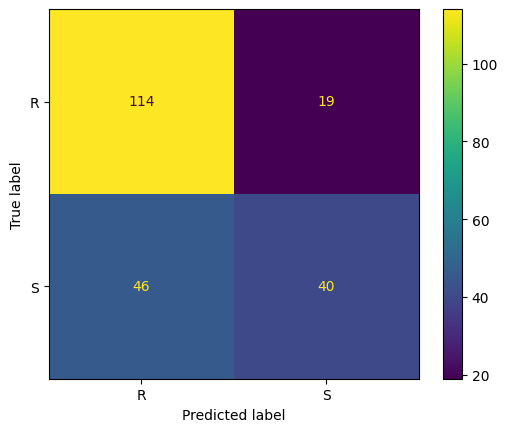

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7072 - loss: 0.6364
Results
Accuracy: 0.7031963467597961
R recall: 0.8571428571428571
S recall: 0.46511627906976744
R precision: 0.7125
S precision: 0.6779661016949152


In [36]:
Model_Report = evaluate(NN_AMX_GY_model,AMX_GY_test_df, AMX_Train_test_dic['labels_test'],AMX_GY_labels_pred)

In [37]:
hparam = {"lr":[0.0001, 0.001],
          "rate":[0.4, 0.8]}

In [38]:
def NN_hp_tune(param, feat_train_df, lab_train, drug, combo, v=3, lr=0.0001, rate=0.8, cv=4):
  NNmodel = KerasClassifier(model=run_NN, verbose=0, lr=lr, rate=rate,
                            feat_train_df = feat_train_df, lab_train=lab_train,
                            drug=drug, combo=combo, view_training = False)
  scoring_dic = {'f1_macro':make_scorer(f1_score , average='macro')}

  feat = feat_train_df.drop(columns=['MLST'])
  scaler = MinMaxScaler()
  feat_t = scaler.fit_transform(feat)
  if str(cv).isnumeric():
    cv = KFold(cv)
    gs = GridSearchCV(NNmodel, hparam, scoring=scoring_dic,cv=cv, refit='f1_macro', verbose=v, return_train_score=True)
    gs.fit(feat_t, lab_train.to_numpy(dtype=float), verbose=0)
    print(gs.best_params_)
    print(gs.best_score_)
    K.clear_session()
    return gs.best_estimator_
  elif cv == "blocked":
    groups= feat_train_df['MLST']
    cv = StratifiedGroupKFold(n_splits=4)
    gs = GridSearchCV(NNmodel, hparam , scoring=scoring_dic, cv=cv, refit='f1_macro', verbose=v, return_train_score=True)
    gs.fit(feat_t, lab_train.to_numpy(dtype=float), verbose=0, groups=groups)
    print(gs.best_params_)
    print(gs.best_score_)
    K.clear_session()
    return gs.best_estimator_
  else:
    print("Please input for cv argument 'blocked' or an integer")

In [39]:
import os
from google.colab import drive
drive.mount('/content/drive')

seed_value= 42

os.environ['PYTHONHASHSEED']=str(seed_value)

import random 
random.seed(seed_value)

import numpy as np 
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)

filepath = '/content/drive/My Drive/EColi_ML_CSV_files/'

import pandas as pd 
All_Drugs_df = pd.read_csv(filepath+"EColi_Merged_df.csv", na_values="NaN")

drug_list = All_Drugs_df.iloc[:,3:15].columns

for drug in drug_list:
  All_Drugs_df.loc[All_Drugs_df[drug] == "S", drug] = 1.0

for drug in drug_list:
  All_Drugs_df.loc[All_Drugs_df[drug] == "R", drug] = 0.0

from sklearn.model_selection import train_test_split

def Split_train_test(drug):
  df_list = [All_Drugs_df[["MLST","Isolate",drug,"Year"]], All_Drugs_df.iloc[:,15:]]

  Drug_df = pd.concat(df_list, axis=1)

  Drug_df = Drug_df.dropna()

  Train_test_dic = {}

  labels = Drug_df[drug]

  features = Drug_df.drop(columns=[drug])

  features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.20, random_state=seed_value, stratify=labels)

  Train_test_dic['labels_train'] = labels_train
  Train_test_dic['features_train'] = features_train
  Train_test_dic['labels_test'] = labels_test
  Train_test_dic['features_test'] = features_test

  return Train_test_dic

AMX_Train_test_dic = Split_train_test("AMX")

print("AMX")
for k, df in AMX_Train_test_dic.items():
  print(k, df.shape)
  if k.startswith("labels"):
    print(df.value_counts())

combo_list = ['Y', 'G', 'GY']

def combo_feat(features_df, drug, combo):

  year_filter = [col for col in features_df if col.startswith("Year")]
  year_feat = features_df[year_filter]

  gene_presc_filter = [col for col in features_df.columns if col not in year_filter and col != "Isolate"]
  gene_presc_feat = features_df[gene_presc_filter]

  if combo == 'Y':
    df_list = [features_df[['MLST','Isolate']], year_feat]
    Y_feat_df_t = pd.concat(df_list, axis=1)
    Y_feat_df_t = Y_feat_df_t.drop(columns=['Isolate'])
    return Y_feat_df_t

  if combo == 'G':
    df_list = [features_df['Isolate'], gene_presc_feat]
    G_feat_df = pd.concat(df_list, axis=1)
    G_feat_df = G_feat_df.drop(columns=['Isolate'])
    return G_feat_df

  if combo == 'GY':
    df_list = [features_df['Isolate'], year_feat, gene_presc_feat]
    GY_feat_df_t = pd.concat(df_list, axis=1)
    GY_feat_df_t = GY_feat_df_t.drop(columns=['Isolate'])
    return GY_feat_df_t

AMX_GY_train_df = combo_feat(AMX_Train_test_dic['features_train'],"AMX","GY")

AMX_GY_train_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-39-84eb4002671d>:29: DtypeWarning: Columns (5,6,7,8,10,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  All_Drugs_df = pd.read_csv(filepath+"EColi_Merged_df.csv", na_values="NaN")


AMX
labels_train (875,)
AMX
0.0    529
1.0    346
Name: count, dtype: int64
features_train (875, 17201)
labels_test (219,)
AMX
0.0    133
1.0     86
Name: count, dtype: int64
features_test (219, 17201)


,Year,MLST,yeiU,yhhS,ybaE,eutR,ibrB,ytfP,aslB,narQ,...,group_48768,group_48873,group_48916,group_48933,group_48937,group_48958,group_49020,group_49174,group_49253,group_49257
662,2002.0,ST641,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
75,2005.0,ST73,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
196,2006.0,ST405,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
540,2009.0,ST415,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
127,2006.0,ST131,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [40]:
print(drug_list[9:13])

print(combo_list)

Index(['TBM', 'TMP', 'CIP'], dtype='object')
['Y', 'G', 'GY']


In [41]:
for fname in os.listdir(filepath):
    if fname.endswith('NN_metrics_df.csv'):
        print("A csv with stored results for Neural Network has already been created. Please check your Google Drive directory.")
        break
else:
  NN_model_metrics = {}

  for drug in drug_list:
    print(drug)
    Test_Train_dic = Split_train_test(drug)
    for combo in combo_list:
      labels_train = Test_Train_dic["labels_train"]
      features_train = combo_feat(Test_Train_dic["features_train"], drug, combo)

      NN_combo_model = run_NN(features_train, labels_train, drug=drug, combo=combo, view_epoch=1)

      features_test = combo_feat(Test_Train_dic["features_test"], drug, combo) 
      labels_pred = predict(NN_combo_model, features_test) 

      labels_test = Test_Train_dic["labels_test"]
      report = evaluate(NN_combo_model, features_test, labels_test, labels_pred, cf=False, show_results= False, tunned=False)


      NN_model_metrics[drug+"_"+combo] = report

      print(report)
      K.clear_session()
  NN_metrics = pd.DataFrame.from_dict(NN_model_metrics, orient='index',columns=["Accuracy", "R_recall", "S_recall", "R_precision", "S_precision"]).reset_index()
  NN_metrics = NN_metrics.rename(columns = {'index':'Drug_combo'})

  NN_metrics.to_csv(filepath+"NN_metrics_df_part4.csv", index= False)

Output hidden; open in https://colab.research.google.com to view.